In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import zoom

--- 
# Pupil Code

In [10]:
def get_aperture(size, radius=None):
    """
    Produces an array to be used to represent the magnitude of light at the aperture of a telescope.
    Ie an array of zeros with a circle of ones at the centre
    Parameters:
        size: The size of the array to return
        radius (optional): The radius which defines the boundary of the aperture, if left as None it
        will extend the aperture to the edged of the array (ie radius = size/2)
    Returns:
        aperture: An array of zeros with a circular section in the middle of ones
    """
    c = size/2
    xs = np.linspace(-c, c, size, endpoint=False)
    Xs, Ys = np.meshgrid(xs, xs)
    Rs = np.hypot(Xs, Ys)
    
    if radius is None:
        aperture = np.where(Rs > c, 0, np.ones([size, size]))
    else:
        aperture = np.where(Rs > radius, 0, np.ones([size, size]))
    return aperture

def get_toliman_pupil(size, path=None):
    """
    Loads in the Toliman pupil file and returns a scaled version of dimension 'size'. 
    The pupil is returned as a complex array.
    Parameters:
        size: The size of the final output array
        path (optional): The path to the "Toliman_pupil.npy" file. If left as None it will
        look for the file in the current working directory
    Returns:
        toliman_pupil_scaled: A scaled version of the Toliman pupil returned as a complex array
    """
    if path is None:
        toliman_pupil = np.load("Toliman_pupil.npy")
    else:
        toliman_pupil = np.load("{}/Toliman_pupil.npy".format(path))
        
    phase = np.angle(toliman_pupil)
    magnitude = np.abs(toliman_pupil)
    size_in = phase.shape[0]
    ratio = float(size/size_in)
    phase_scaled = zoom(phase, ratio, order=0)
    toliman_pupil_out = get_aperture(size) * np.exp(1j * phase_scaled)
    return toliman_pupil_out

In [11]:
pupil = get_toliman_pupil(512)

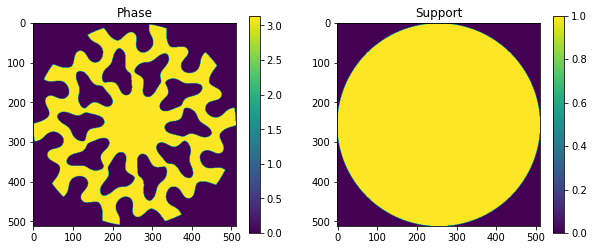

In [12]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.angle(pupil))
plt.title("Phase")
plt.colorbar()

plt.subplot(1, 2, 2)
plt.title("Support")
plt.imshow(np.abs(pupil))
plt.colorbar()
plt.show()

---

# Zemax Code

*Shudder*

In [8]:
def zemax_to_array(path_to_file):
    """
    Coverts Zemax .txt files to numpy arrays
    """
    with open(path_to_file,'rb') as f:
        contents = f.read()
        
    contents = contents.decode("utf-16").split("\n")
    data_raw = [line.strip() for line in contents]
    
    metadata = []
    data = []
    
    for line in data_raw[:20]:
        if line != '':
            metadata.append(line)
            
    for line in data_raw[21:-1]:
        line = line.split("\t  ")
        line_formatted = [float(l) for l in line if l != '']
        data.append(line_formatted)
        
    return np.asarray(data), metadata

def create_sag_file(file_name, pupil, aperture, unit, target_wl):
    """
    Creates a sag file formatted for Zemax
    file_name: Name for the file
    Pupil: complex array
    unit: unit of measurement {"mm": 0, "cm": 1, "in": 2, "m": 3}
    aperture: telescope aperture in units of 'unit'
    target_wl: ideal wavelength in units of 'unit'
    """
    unit_dict = {"mm": 0, "cm": 1, "in": 2, "m": 3}
    phase_range = 2*np.pi
    
    nx = pupil.shape[0]
    ny = pupil.shape[1]
    delx = aperture/nx
    dely = aperture/ny
    unitflag  = unit_dict[unit]
    xdec = 0
    ydec = 0
    
    with open("{}.DAT".format(file_name), 'w') as f:
        f.write("{} {} {} {} {} {} {}\n".format(nx, ny, delx, dely, unitflag, xdec, ydec))
        
        for i in range(nx):
            for j in range(ny):
                sag_ratio = np.angle(pupil[i][j])/phase_range
                sag_val = sag_ratio*target_wl/2
                if sag_val < 1e-12:
                    sag_val = 0
                    
                f.write("{} {} {} {} {}\n".format(float(sag_val), 0, 0, 0, 0))
                
def create_phase_file(file_name, pupil, aperture, unit):
    """
    Creates a sag file formatted for Zemax
    file_name: Name for the file
    Pupil: complex array
    unit: unit of measurement {"mm": 0, "cm": 1, "in": 2, "m": 3}
    aperture: telescope aperture in units of 'unit'
    """
    unit_dict = {"mm": 0, "cm": 1, "in": 2, "m": 3}
    
    nx = pupil.shape[0]
    ny = pupil.shape[1]
    delx = aperture/nx
    dely = aperture/ny
    unitflag  = unit_dict[unit]
    xdec = 0
    ydec = 0
    
    phases = []
    
    with open("{}.DAT".format(file_name), 'w') as f:
        f.write("{} {} {} {} {} {} {}\n".format(nx, ny, delx, dely, unitflag, xdec, ydec))
        
        for i in range(nx):
            for j in range(ny):
                phase_val = np.angle(pupil[i][j])
                
                if phase_val not in phases:
                    phases.append(phase_val)
                    
                if phase_val < 1e-12:
                    phase_val = 0
                f.write("{} {} {} {} {}\n".format(float(phase_val), 0, 0, 0, 0))  
#     print(phases)